In [1]:
import os
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


__version__ = "0.1" 

In [3]:
eps =  np.finfo(float).eps


node_directory = os.getcwd()

data = np.load('/home/mass_spec_img/mass_spec_img/data/npy/SQ1631_s1_R.npy')
nsamples, nx, ny = data.shape
data = data.reshape((nsamples,nx*ny))
k = 3
algorithm = "PCA"
keep_n_cols = 0



def colnorm(X):
    return X / np.sum(X, axis=0, keepdims=True)


def plsa(X, numComponents, relativeChange=1e-4, maxIter=1000):
    Xt = np.transpose(X)
    (numChannels, numSpectra) = Xt.shape

    ct = colnorm(np.random.rand(numChannels, numComponents));
    ts = colnorm(np.ones((numComponents, numSpectra)))

    lastChange = 1.0 / eps
    err = 1e10
    iteration = 0

    while (lastChange > relativeChange) and (iteration < maxIter):
        ts = colnorm(np.multiply(ts, np.matmul(np.transpose(ct), np.divide(Xt, (np.matmul(ct, ts) + eps)))))
        ct = colnorm(np.multiply(ct, np.matmul(np.divide(Xt, (np.matmul(ct,ts) + eps)), np.transpose(ts))))
|
        model = np.multiply(np.matmul(np.ones((numChannels, 1)), np.sum(Xt, axis=0, keepdims=True)), np.matmul(ct, ts))
        errold = err
        err = np.sum(np.square(np.subtract(Xt, model)))
        
        lastChange = abs((err - errold) / err)
        iteration = iteration + 1

        if not (iteration % 25 ):
            print(f"Iteration {iteration}: relative change is {lastChange}")

    loglik = np.sum(np.multiply(Xt, np.log(np.matmul(ct, ts) + eps)))

    return((ct, ts, loglik))  





in_dim = len(data[0])

if algorithm == "PLSA":
    (ct, wt, loglik) = plsa(data, k)
    out_data = np.transpose(wt)

if algorithm == "PCA":
    pca_data = StandardScaler().fit_transform(data)
    pca = PCA(n_components=k)
    out_data = pca.fit_transform(pca_data)


with open(f"{node_directory}/reduced.tsv", 'w') as out:
    #headers[:keep_n_cols] + list(map(lambda x: f"Dim{x + 1}", range(k)))
    #print(headers, file=out)
    for row in out_data:
        rounded = list(map(lambda x: f"{x}", np.round(row, 3)))
        print("\t".join(rounded), file=out)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 44)

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
plt.figure(figsize=(8, 6))
plt.scatter(out_data[:, 0], out_data[:, 1], c='blue', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot (2D)')
plt.grid(True)
plt.show()

NameError: name 'out_data' is not defined

<Figure size 800x600 with 0 Axes>

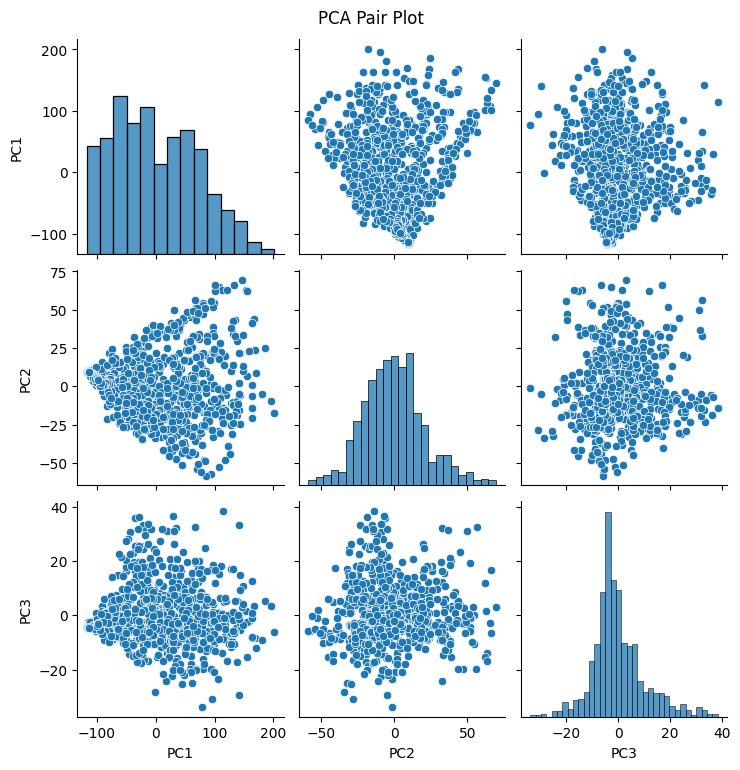

In [25]:
pca_df = pd.DataFrame(out_data, columns=[f'PC{i+1}' for i in range(out_data.shape[1])])

# Use seaborn to plot pairwise relationships
sns.pairplot(pca_df)
plt.suptitle('PCA Pair Plot', y=1.02)
plt.show()